# Sberbank Russian Housing Market

In [1]:
import pandas as pd
from pandas.io.json import build_table_schema
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import missingno as msno
import numpy as np
import scipy as sp
import os
import xgboost as xgb
import seaborn as sns
from sklearn import model_selection, preprocessing
# import visualization as vis
from pandas.plotting import scatter_matrix
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
color = sns.color_palette()

DIR_PATH = './'

In [2]:
pd.__path__

['/usr/local/lib/python2.7/site-packages/pandas']

In [3]:
## loading data as Pandas dataframes
train_raw = pd.read_csv(os.path.join(DIR_PATH, 'train.csv'), 
                        header='infer', 
                        index_col='id',
                        parse_dates=['timestamp'])
test_raw = pd.read_csv(os.path.join(DIR_PATH, 'test.csv'), 
                       header='infer', 
                       index_col='id',
                       parse_dates=['timestamp'])
macro = pd.read_csv(os.path.join(DIR_PATH, 'macro.csv'), 
                    header='infer')

### Data Understanding & Data Preparation

In [4]:
## data schema
train_schema = pd.DataFrame(build_table_schema(train_raw)['fields'])
macro_schema = pd.DataFrame(build_table_schema(macro)['fields'])

In [5]:
## start from property features first
property_features = ['timestamp', 'full_sq', 'life_sq', 'floor', 
                     'max_floor', 'material', 'build_year', 'num_room',
                     'kitch_sq', 'state', 'product_type', 'sub_area', 
                     'price_doc']

train = train_raw[property_features]
test = test_raw[property_features[:-1]]

## Cleaning the property features

## full_sq:

In [6]:
# <10 -> NA
train.loc[train['full_sq'] <10, 'full_sq'] = np.nan
test.loc[test['full_sq'] <10, 'full_sq'] = np.nan

# >300 -> NA
train.loc[train['full_sq'] > 300, 'full_sq'] = np.nan
test.loc[test['full_sq'] > 300, 'full_sq'] = np.nan

## life_sq:

In [7]:
# 0 or 1 -> NA
train.loc[(train['life_sq'] == 0) | (train['life_sq'] == 1), 'life_sq'] = np.nan
test.loc[(test['life_sq'] == 0) | (test['life_sq'] == 1), 'life_sq'] = np.nan

# > 300 -> NA
train.loc[train['life_sq'] > 300, 'life_sq'] = np.nan
test.loc[test['life_sq'] > 300, 'life_sq'] = np.nan

# full_sq < life_sq & life_sq > 100 -> NA
train.loc[(train['full_sq'] < train['life_sq']) & (train['life_sq'] > 100), 'life_sq'] = np.nan
test.loc[(test['full_sq'] < test['life_sq']) & (test['life_sq'] > 100), 'life_sq'] = np.nan

## max_floor:

In [8]:
# # 117 -> 17
train.loc[train['max_floor'] == 117, 'max_floor'] = 17
test.loc[test['max_floor'] == 117, 'max_floor'] = 17

# floor > max_floor -> NA
train.loc[train['floor'] > train['max_floor'], 'max_floor'] = np.nan
test.loc[test['floor'] > test['max_floor'], 'max_floor'] = np.nan

# >60 -> NA
train.loc[train['max_floor'] > 60, 'max_floor'] = np.nan
test.loc[test['max_floor'] > 60, 'max_floor'] = np.nan

# 0 -> NA
train.loc[train['max_floor'] == 60, 'max_floor'] = np.nan
test.loc[test['max_floor'] == 60, 'max_floor'] = np.nan

## material:

In [9]:
# 3 -> NA
col = 'material'
train.loc[train[col] == 3, col] = np.nan
test.loc[test[col] == 3, col] = np.nan

## build_year:

In [10]:
# 20052009 -> 2009 
train.loc[train['build_year'] == 20052009, 'build_year'] = 2009
test.loc[test['build_year'] == 20052009, 'build_year'] = 2009

#  4965 -> 1965
train.loc[train['build_year'] == 4965, 'build_year'] = 1965
test.loc[test['build_year'] == 4965, 'build_year'] = 1965

#  71 -> 1971
train.loc[train['build_year'] == 71, 'build_year'] = 1971
test.loc[test['build_year'] == 71, 'build_year'] = 1971

#  <1800 -> NA
train.loc[train['build_year'] < 1800, 'build_year'] = np.nan
test.loc[test['build_year'] < 1800, 'build_year'] = np.nan

## num_room:

In [11]:
# >9 -> NA
train.loc[train['num_room'] > 9, 'num_room'] = np.nan
test.loc[test['num_room'] > 9, 'num_room'] = np.nan

## kitch_sq:

In [12]:
# kitch_sq > full_sq & kitch_sq > 100 -> NA
train.loc[(train['kitch_sq'] > train['full_sq']) & (train['kitch_sq'] > 100), 'kitch_sq'] = np.nan
test.loc[(test['kitch_sq'] > test['full_sq']) & (test['kitch_sq'] > 100), 'kitch_sq'] = np.nan

## state:

In [13]:
## 33 -> 3
train.loc[train['state'] == 33, 'state'] = 3
test.loc[test['state'] == 33, 'state'] = 3

# Merging

### Merge cleaned datasets with raw datasets

Merging the datasets (raw and cleaned):

In [14]:
train_raw_small = train_raw.ix[:, train_raw.columns.difference(property_features)]

property_features_test = ['timestamp', 'full_sq', 'life_sq', 'floor', 
                     'max_floor', 'material', 'build_year', 'num_room',
                     'kitch_sq', 'state', 'product_type', 'sub_area']
test_raw_small = test_raw.ix[:, test_raw.columns.difference(property_features_test)]

In [15]:
merged_df_train = pd.concat([train, train_raw_small], axis=1)
merged_df_test = pd.concat([test, test_raw_small], axis=1)

In [16]:
# saving the datasets to csvs
merged_df_train.to_csv('train_cleaned.csv')
merged_df_test.to_csv('test_cleaned.csv')

### Merge cleaned datasets with macro

Merging the newly created dataset with macro (for train dataset):

In [17]:
macro.timestamp = pd.to_datetime(macro.timestamp)

In [18]:
print type(merged_df_train.timestamp.iloc[0])
print type(macro.timestamp.iloc[0])

<class 'pandas._libs.tslib.Timestamp'>
<class 'pandas._libs.tslib.Timestamp'>


In [19]:
# make id as a column. If we keep it as an index, it gets dropped when we merge
merged_df_train['id'] = merged_df_train.index
merged_df_test['id'] = merged_df_test.index

In [20]:
pd_full_train = pd.merge(merged_df_train, macro, on = 'timestamp', how='left')
pd_full_test = pd.merge(merged_df_test, macro, on = 'timestamp', how='left')

# Missing Values

### Looking at missing values (after a little bit of cleaning)

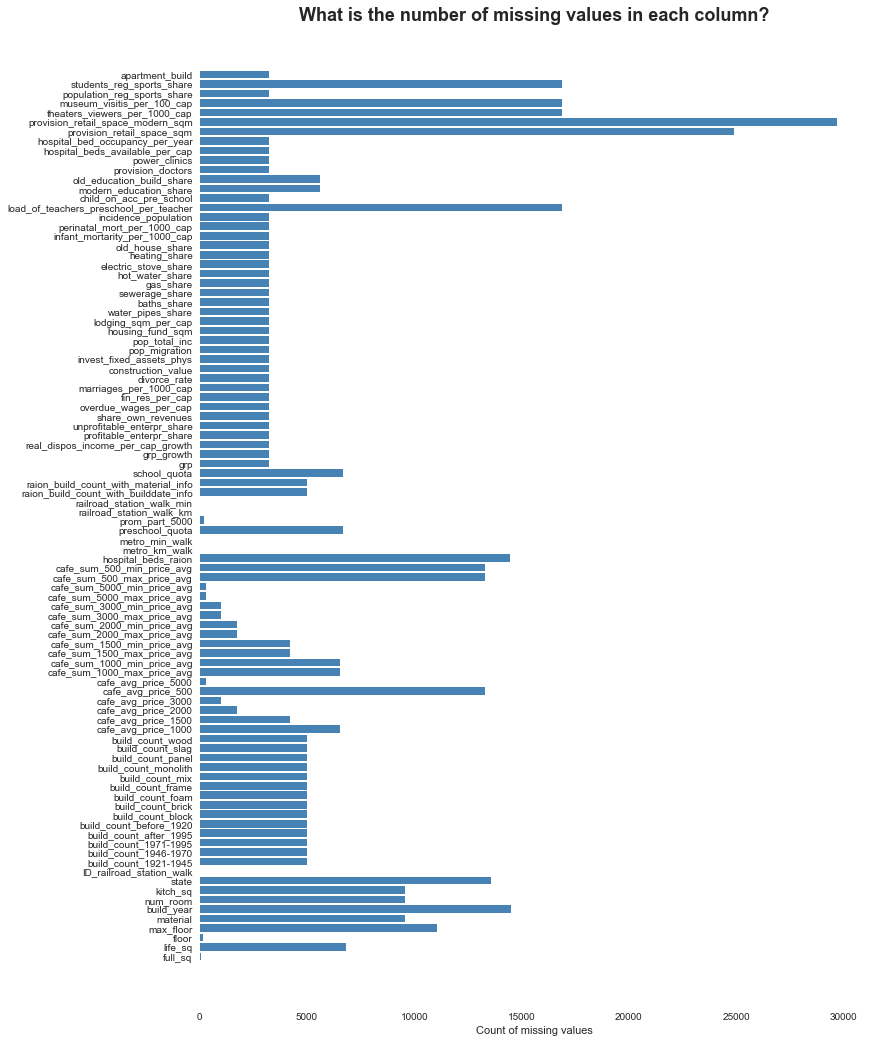

In [21]:
missing_df = pd_full_train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='steelblue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("What is the number of missing values in each column?", weight = 'bold', size = 18)
ax.set_axis_bgcolor('white')
plt.show()

# Important Variables

### Doing feature selection using RF and XG boost. 
We will use EDA to refine the process of selecting our features.

#### Using XGboost

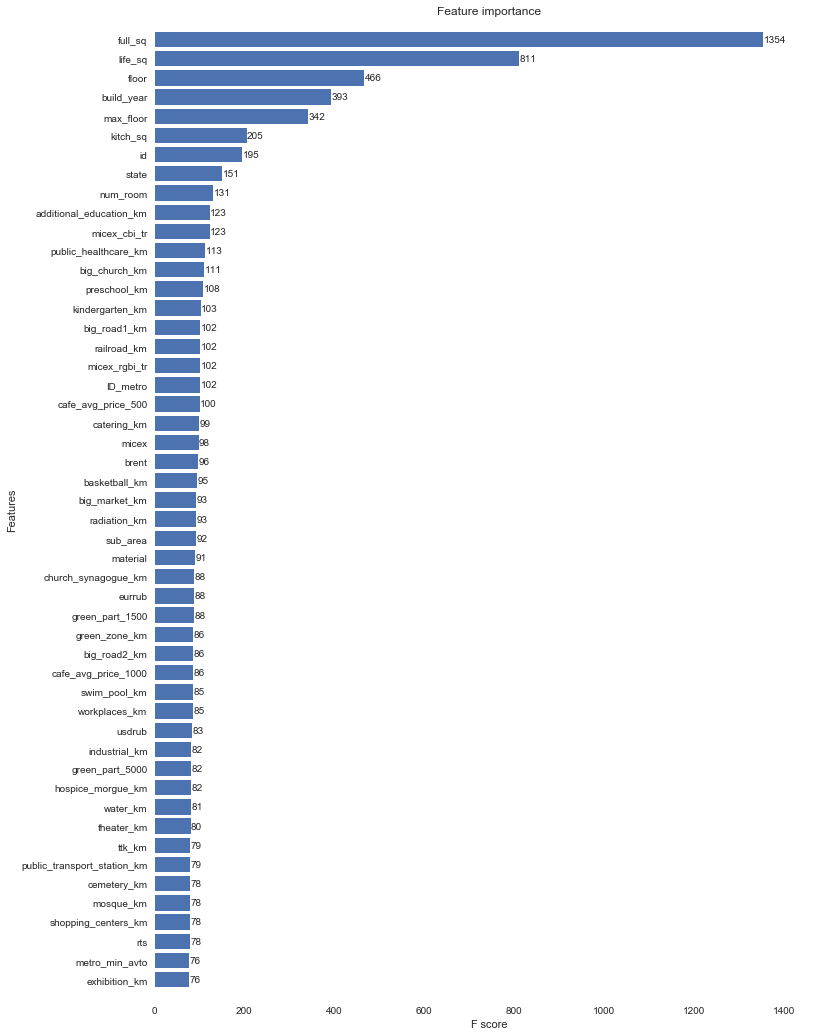

In [199]:
for f in pd_full_train.columns:
    if pd_full_train[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(pd_full_train[f].values)) 
        pd_full_train[f] = lbl.transform(list(pd_full_train[f].values))
        
train_y = pd_full_train.price_doc.values
train_X = pd_full_train.drop(["timestamp", "price_doc"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.set_axis_bgcolor('white')
plt.show()

#### Using Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
X_train = train_raw.drop(labels=['timestamp', 'incineration_raion'], axis=1).dropna()
y_train = X_train['price_doc']
X_train.drop('price_doc', axis=1, inplace=True)
for f in X_train.columns:
    if X_train[f].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(X_train[f])
        X_train[f] = lbl.transform(X_train[f])
rf = RandomForestRegressor(random_state=0)
rf = rf.fit(X_train, y_train)

In [45]:
fi = list(zip(X_train.columns, rf.feature_importances_))
print('## rf variable importance')
d = ['## %-40s%s' % (i) for i in fi[:20]]
d

## rf variable importance


['## full_sq                                 0.555822740983',
 '## life_sq                                 0.00642379194562',
 '## floor                                   0.00809202108709',
 '## max_floor                               0.0028673165125',
 '## material                                0.000990753188025',
 '## build_year                              0.0129793747626',
 '## num_room                                0.00160862516711',
 '## kitch_sq                                0.00737577768977',
 '## state                                   0.00300109689575',
 '## product_type                            0.000774585117786',
 '## sub_area                                0.000408328391516',
 '## area_m                                  0.0002262017504',
 '## raion_popul                             0.000110012923241',
 '## green_zone_part                         0.00323341734379',
 '## indust_part                             0.00195929983016',
 '## children_preschool                  

# Feature Selection

#### Now that we have a good understanding of the important variables, we'll do a quick EDA to refine our feature selection process.

In [22]:
# truncate the extreme values in price_doc #
ulimit = np.percentile(pd_full_train.price_doc.values, 99)
llimit = np.percentile(pd_full_train.price_doc.values, 1)
pd_full_train['price_doc'].ix[pd_full_train['price_doc']>ulimit] = ulimit
pd_full_train['price_doc'].ix[pd_full_train['price_doc']<llimit] = llimit

Convert categorical variables into numerical variables by label encoding.

In [23]:
for f in pd_full_train.columns:
    if pd_full_train[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(pd_full_train[f].values.astype('str')) + list(pd_full_test[f].values.astype('str')))
        pd_full_train[f] = lbl.transform(list(pd_full_train[f].values.astype('str')))
        pd_full_test[f] = lbl.transform(list(pd_full_test[f].values.astype('str')))

product_type
sub_area
big_market_raion
big_road1_1line
culture_objects_top_25
detention_facility_raion
ecology
incineration_raion
nuclear_reactor_raion
oil_chemistry_raion
radiation_raion
railroad_1line
railroad_terminal_raion
thermal_power_plant_raion
water_1line
child_on_acc_pre_school
modern_education_share
old_education_build_share


Create dataset with only the variables from XG Boost algorithm

In [102]:
xgb_features = ["full_sq", "life_sq", "floor", "build_year", "max_floor", "kitch_sq",
           "state", "additional_education_km", "public_transport_station_km", 
           "num_room", "ID_metro", "big_church_km", "sub_area",
           "preschool_km", "cafe_avg_price_500", "big_road2_km", "green_zone_km",
          "kindergarten_km", "catering_km", "big_road1_km", 
           "public_healthcare_km", "hospice_morgue_km", "swim_pool_km", "material", 
           "green_part_1000", "railroad_km", "industrial_km", "cemetery_km",
           "fitness_km", "theater_km", "radiation_km", "id", "price_doc", "timestamp",
            "raion_popul", "area_m", "young_all", "work_all", "ekder_all", "full_all",
            "children_school", "school_quota", "children_preschool", "preschool_quota"] # adding "raion_popul", "area_m",
            # "young_all", "work_all", "ekder_all", "full_all", "children_school", "school_quota", "children_preschool", 
            # "preschool_quota", for feature engineering

xgb_features_noprice = ["full_sq", "life_sq", "floor", "build_year", "max_floor", "kitch_sq",
           "state", "additional_education_km", "public_transport_station_km", 
           "num_room", "ID_metro", "big_church_km", "sub_area",
           "preschool_km", "cafe_avg_price_500", "big_road2_km", "green_zone_km",
          "kindergarten_km", "catering_km", "big_road1_km", 
           "public_healthcare_km", "hospice_morgue_km", "swim_pool_km", "material", 
           "green_part_1000", "railroad_km", "industrial_km", "cemetery_km",
           "fitness_km", "theater_km", "radiation_km", "id","timestamp",
           "raion_popul", "area_m", "young_all", "work_all", "ekder_all", "full_all",
           "children_school", "school_quota", "children_preschool", "preschool_quota"] # adding "raion_popul", "area_m",
            # "young_all", "work_all", "ekder_all", "full_all", "children_school", "school_quota", "children_preschool", 
            # "preschool_quota", for feature engineering

In [103]:
train_reduced_xgboost = pd_full_train[xgb_features]
test_reduced_xgboost = pd_full_test[xgb_features_noprice]

#### Checking proportion of null values in reduced train and test datasets:

In [104]:
null_values_train = train_reduced_xgboost.isnull().sum(axis=0) / len(train_reduced_xgboost) * 100
null_values_train[null_values_train > 0]

full_sq                0.141118
life_sq               22.427882
floor                  0.548062
build_year            47.612484
max_floor             36.323061
kitch_sq              31.429884
state                 44.498047
num_room              31.426602
cafe_avg_price_500    43.585704
material              31.416757
school_quota          21.938893
preschool_quota       21.948738
dtype: float64

In [105]:
null_values_test = test_reduced_xgboost.isnull().sum(axis=0) / len(test_reduced_xgboost) * 100
null_values_test[null_values_test > 0]

full_sq                0.065257
life_sq               19.720700
build_year            20.973636
max_floor              8.392065
kitch_sq               0.026103
state                  9.057687
num_room               0.013051
cafe_avg_price_500    41.229444
material               0.013051
school_quota          20.817019
preschool_quota       20.830070
dtype: float64

The **variables that are worth looking at for imputation** are: `life_sq`, `build_year`, `max_floor`, `kitch_sq`, `state`, `num_room`, `cafe_avg_price_500` and `material`.

For the 2 other variable with a low number of null values in both the test and train datasets (i.e. `full_sq` and `floor`), we will use the median (`full_sq`) and mode (`floor`).

### life_sq

We may be able to infer the values for `life_sq` from `full_sq` or **dismiss these values altogether if they are correlated to `full_sq`.**

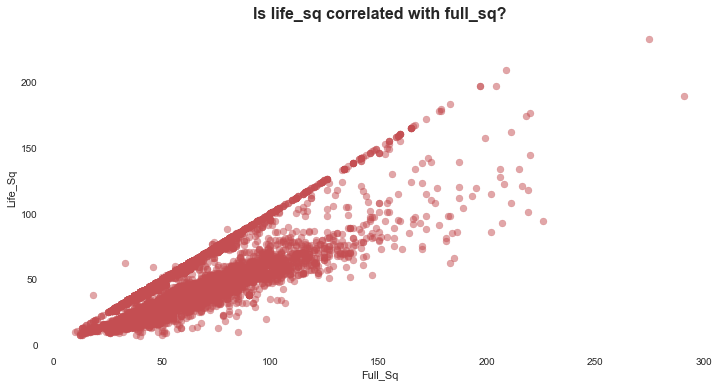

In [91]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_axis_bgcolor('white')
plt.scatter(x=train_reduced_xgboost.drop(ind)['full_sq'], y=train_reduced_xgboost.drop(ind)['life_sq'], color=color[2], alpha=0.5)
ax.set(xlabel='Full_Sq', ylabel='Life_Sq')
ax.set_title('Is life_sq correlated with full_sq?',fontsize=16, weight='bold')

In [92]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod = ols('full_sq ~ life_sq',
                data=train_reduced_xgboost).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

                sum_sq       df             F  PR(>F)
life_sq   7.375627e+06      1.0  60111.740272     0.0
Residual  2.898264e+06  23621.0           NaN     NaN


In [30]:
# eta squared. It is calculated the same way as R squared.
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
esq_sm # out of the total variation in life_sq, 72% can be attributed to a full_sq.

0.71790007202278538

##### We won't use life_sq as it is highly correlated with full_sq. No need to impute missing values.

### build_year

Is `build_year` correlated with another variable? It could be correlated to `state`. However `state` has a lot of missing variables so if there are correlated, we may prefer to keep `build_year` and drop `state`.

##### Checking the correlation between `build_year` and `state`

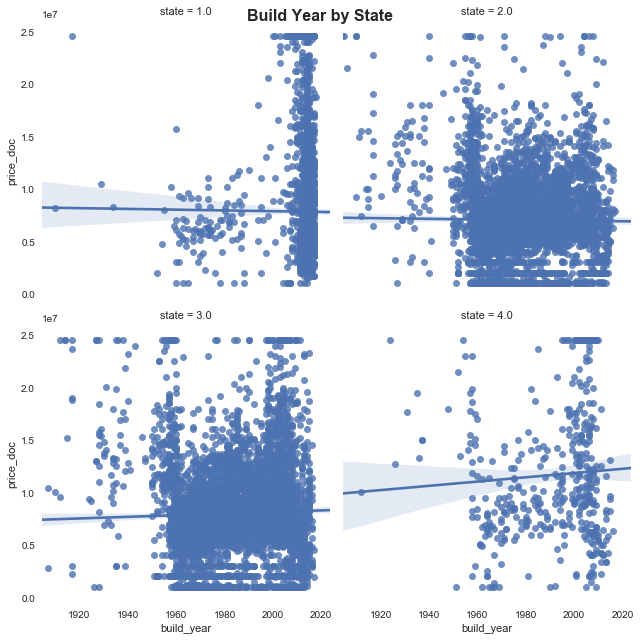

In [31]:
g = sns.FacetGrid(train_reduced_xgboost, col="state", col_wrap=2, size=4.5) 
g.set(axis_bgcolor='white')
g.fig.suptitle('Build Year by State', size = 16, weight = 'bold')
g.map(sns.regplot, "build_year", "price_doc") 

It is hard to see a relationship between `state` and `build_year`. There does not seem to be a relationship between neither `build_year` and `price` nor `build_year` and `state`.

**We can't infer build_year from another variable and will need to find a way to impute it.**

### max_floor

Can we infer max_floor from another variable? E.g. **is max_floor correlated with build_year?**

In [32]:
grouped_df = train_reduced_xgboost.groupby('build_year')['max_floor'].aggregate(np.mean).reset_index()

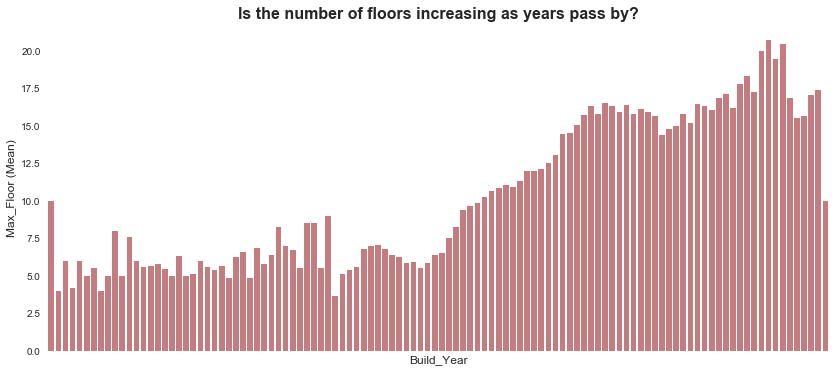

In [33]:
import matplotlib.ticker as ticker
from matplotlib.ticker import *

fig, ax = plt.subplots(figsize=(14,6))
ax.set_axis_bgcolor('white')
sns.barplot(grouped_df['build_year'], grouped_df['max_floor'], alpha=0.8, color=color[2])
plt.ylabel('Max_Floor (Mean)', fontsize=12)
plt.xlabel('Build_Year', fontsize=12)
ax.set_title("Is the number of floors increasing as years pass by?",fontsize=16, weight='bold')
# plt.xticks(rotation='vertical')
ax.set_xticks([])
plt.show()

**The number of floors increase has the years pass by**. Taking a closer look at the correlation between `build_year` and `max_floor`:

In [34]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod = ols('build_year ~ max_floor',
                data=train_reduced_xgboost).fit()
                
aov_table_2 = sm.stats.anova_lm(mod, typ=2)
print aov_table_2

                 sum_sq       df            F  PR(>F)
max_floor  2.812396e+06      1.0  11407.75674     0.0
Residual   3.840994e+06  15580.0          NaN     NaN


In [35]:
# eta squared. It is calculated the same way as R squared.
esq_sm = aov_table_2['sum_sq'][0]/(aov_table_2['sum_sq'][0]+aov_table_2['sum_sq'][1])
esq_sm # out of the total variation in max_floor, 42% can be attributed to the build year.

0.42270118445866595

**The eta squared is too low between `max_floor` and `build_year`**. We will keep both variables and will need to impute `max_floor`.

### kitch_sq

Is there a correlation between kitch_sq and full_sq?

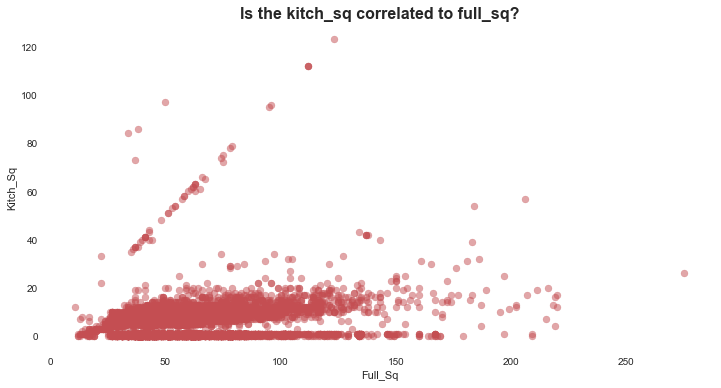

In [36]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_axis_bgcolor('white')
plt.scatter(x=train_reduced_xgboost.drop(ind)['full_sq'], y=train_reduced_xgboost.drop(ind)['kitch_sq'], color=color[2], alpha=0.5)
ax.set(xlabel='Full_Sq', ylabel='Kitch_Sq')
ax.set_title("Is the kitch_sq correlated to full_sq?",fontsize=16, weight='bold')

In [37]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod = ols('kitch_sq ~ full_sq',
                data=train_reduced_xgboost).fit()
                
aov_table_2 = sm.stats.anova_lm(mod, typ=2)
print aov_table_2

                 sum_sq       df           F         PR(>F)
full_sq    12428.421821      1.0  499.116679  2.828382e-109
Residual  519456.308563  20861.0         NaN            NaN


**There is no clear correlation between kitch_sq and full_sq.** The p-value is too high.
We can't dismiss `kitch_sq` in our modeling and will need to impute it.

### state

We already saw that there was no relationship between `state` and `build_year`. **Is there a relationship between `state` and `material`?**

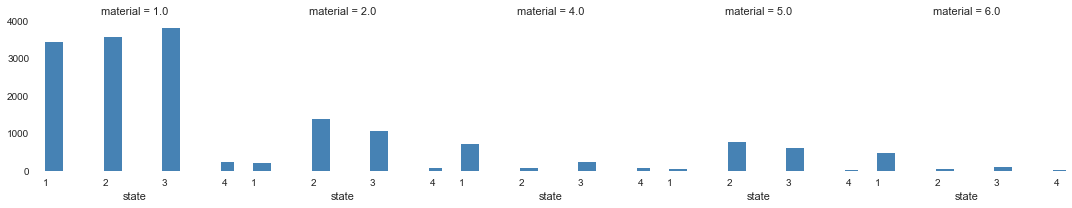

In [38]:
g = sns.FacetGrid(train_reduced_xgboost, col="material") 
g.set(axis_bgcolor='white')
# g.fig.suptitle('State by Material', size = 16, weight = 'bold')
bins = np.linspace(1, 4)
g.map(plt.hist, "state", color="steelblue", bins=bins, lw=0, width = 0.3)

**`Material` is not a good predictor of `state`**. We will need to choose a different way to impute `state`.

### num_room

Looking for a possible correlation between `num_room` and `full_sq`:

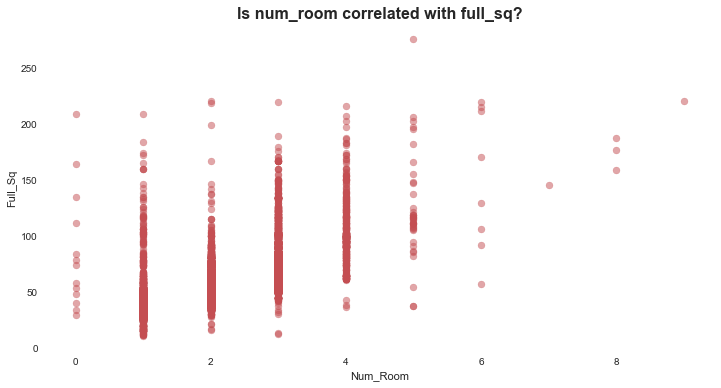

In [39]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_axis_bgcolor('white')
plt.scatter(x=train_reduced_xgboost.drop(ind)['num_room'], y=train_reduced_xgboost.drop(ind)['full_sq'], 
            color=color[2], alpha=0.5)
ax.set(xlabel='Num_Room', ylabel='Full_Sq')
ax.set_title('Is num_room correlated with full_sq?',fontsize=16, weight='bold')

In [40]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod = ols('full_sq ~ num_room',
                data=train_reduced_xgboost).fit()
                
aov_table_3 = sm.stats.anova_lm(mod, typ=2)
print aov_table_3

                sum_sq       df             F  PR(>F)
num_room  5.113924e+06      1.0  27633.667889     0.0
Residual  3.860750e+06  20862.0           NaN     NaN


In [41]:
# eta squared. It is calculated the same way as R squared.
esq_sm = aov_table_3['sum_sq'][0]/(aov_table_3['sum_sq'][0]+aov_table_3['sum_sq'][1])
esq_sm # out of the total variation in num_room, 57% can be attributed to full_sq.

0.56981724537205269

The p-value is low and eta squared relatively high so we can assume a correlation between `full_sq` and `num_room`.
To keep our model as simple as possible, **we will drop `num_room`. The number of missing values is high for `num_room` and given that it is correlated to `full_sq`, it will be more accurate to drop it rather than impute it**.

### cafe_avg_price_500

The variable `cafe_avg_price_500` looks at the cafes and restaurant's average bill within a 500 meters radius. 

In [42]:
train_reduced_xgboost['cafe_avg_price_500'].head(10)

0        NaN
1    1180.00
2     916.67
3    1250.00
4     934.44
5    1312.50
6    1000.00
7    1312.50
8     858.33
9     575.00
Name: cafe_avg_price_500, dtype: float64

Looking at a possible correlation between the `cafe_avg_price_500` and `price_doc`

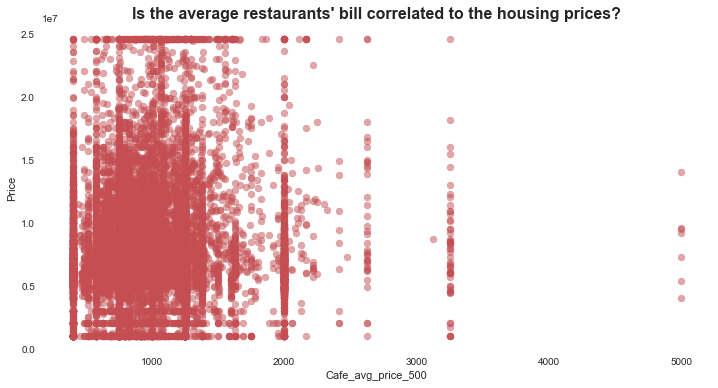

In [43]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_axis_bgcolor('white')
plt.scatter(x=train_reduced_xgboost.drop(ind)['cafe_avg_price_500'], y=train_reduced_xgboost.drop(ind)['price_doc'], 
            color=color[2], alpha=0.5)
ax.set(xlabel='Cafe_avg_price_500', ylabel='Price')
ax.set_title("Is the average restaurants' bill correlated to the housing prices?",fontsize=16, weight='bold')

**No correlation between average restaurants' bill and housing prices**. 
The correlation with `sub_area` is also unclear (not plotted here).

Because there is a high number of missing values for the cafe_avg_price_500 and the correlation with price is weak, we'll drop it.

### material

We already saw that material did not correlate with state. It does not correlate with any features related to the house as shown in the correlation plot below so we'll impute it.

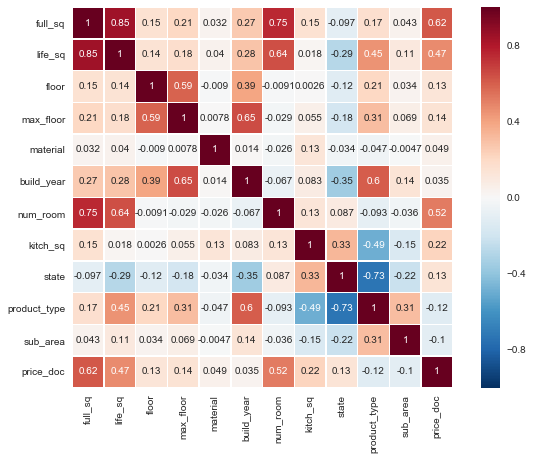

In [44]:
property_features = ['timestamp', 'full_sq', 'life_sq', 'floor', 
                     'max_floor', 'material', 'build_year', 'num_room',
                     'kitch_sq', 'state', 'product_type', 'sub_area', 
                     'price_doc']

corrmat = pd_full_train[property_features].corr()
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

### school

The variables related to `school` were not part of the important variables from the xgboost model. However the variable selection performed by random forest included `children_preschool`, `preschool_quota`, `preschool_education_centers_raion`, `children_school`, `school_quota` as important variables.

We will include them in our model for now and play with them.

##### Looking at the correlation plot for all the school variables to decide the ones to pick:

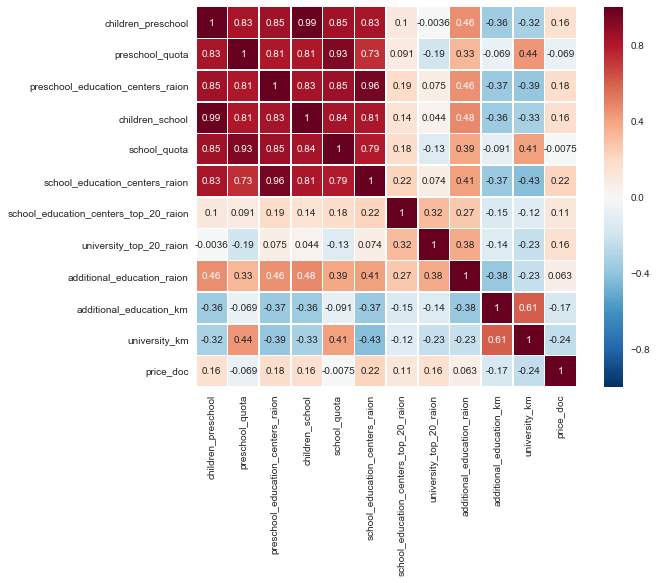

In [45]:
#school features
school_features = ['children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 
                'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 
                'university_top_20_raion', 'additional_education_raion', 'additional_education_km', 'university_km', 'price_doc']

corrmat = pd_full_train[school_features].corr()
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

A few school variables are correlated (i.e. `children_preschool`, `preschool_quota`, `preschool_education_centers_raion`, `children_school`, `school_quota`, `school_education_centers_raion`). None of them seem to be higher correlated to `price_doc` than any other. We will look at the number of missing values and **pick the one that have the least number of missing values.**

In [46]:
school_list = ['children_preschool', 'preschool_quota', 
              'preschool_education_centers_raion', 
              'children_school', 'school_quota', 
              'school_education_centers_raion']
school_df = pd_full_train[school_list]

In [47]:
null_values_school = school_df.isnull().sum(axis=0) / len(school_df) * 100
null_values_school

children_preschool                    0.000000
preschool_quota                      21.948738
preschool_education_centers_raion     0.000000
children_school                       0.000000
school_quota                         21.938893
school_education_centers_raion        0.000000
dtype: float64

Only the `preschool_quote` and `school_quota` have missing values. **We will pick `children_preschool` as an indicator of all the school variables**: it is one of the school features that was selected by the random forest algorithm and it has no missing values.

## Feature Selection Summary

Based on the analysis above, we will perfom the following transformation to the features we selected:
- **DROP**: `life_sq`, `num_room`,  `cafe_avg_price_500` 

*Note: keeping `life_sq`, `num_room` for feature engineering and will drop later* 

- **ADD**: `children_preschool`
- **IMPUTE**: `build_year`, `max_floor`, `state`, `kitch_sq`, `material`
- **KEEP**: all the remaining features

In [48]:
print xgb_features
print xgb_features_noprice

['full_sq', 'life_sq', 'floor', 'build_year', 'max_floor', 'kitch_sq', 'state', 'additional_education_km', 'public_transport_station_km', 'num_room', 'ID_metro', 'big_church_km', 'sub_area', 'preschool_km', 'cafe_avg_price_500', 'big_road2_km', 'green_zone_km', 'kindergarten_km', 'catering_km', 'big_road1_km', 'public_healthcare_km', 'hospice_morgue_km', 'swim_pool_km', 'material', 'green_part_1000', 'railroad_km', 'industrial_km', 'cemetery_km', 'fitness_km', 'theater_km', 'radiation_km', 'id', 'price_doc', 'timestamp', 'raion_popul', 'young_all', 'work_all', 'ekder_all', 'full_all', 'children_school', 'school_quota', 'children_preschool', 'preschool_quota']
['full_sq', 'life_sq', 'floor', 'build_year', 'max_floor', 'kitch_sq', 'state', 'additional_education_km', 'public_transport_station_km', 'num_room', 'ID_metro', 'big_church_km', 'sub_area', 'preschool_km', 'cafe_avg_price_500', 'big_road2_km', 'green_zone_km', 'kindergarten_km', 'catering_km', 'big_road1_km', 'public_healthcare_k

In [106]:
# updating the xgb feature list by adding children_preschool and dropping life_sq and num_room
# xgb_features.append('children_preschool') 
# xgb_features.remove('life_sq')
# xgb_features.remove('num_room')
xgb_features.remove('cafe_avg_price_500')

# xgb_features_noprice.append('children_preschool') 
# xgb_features_noprice.remove('life_sq')
# xgb_features_noprice.remove('num_room')
xgb_features_noprice.remove('cafe_avg_price_500')

In [107]:
train_reduced_xgboost = pd_full_train[xgb_features]
test_reduced_xgboost = pd_full_test[xgb_features_noprice]

# Adding Macro Data

In [108]:
# adding important macro data to the list of features
xgb_features.extend(['usdrub', 'cpi','mortgage_rate', 'micex'])
xgb_features_noprice.extend(['usdrub', 'cpi','mortgage_rate', 'micex'])

# Imputating

#### We have 44 features that we selected:
We will procede to cleaning the missing data as follow:
- remove observations that have more than 10 missing values
- use random to impute missing values for now. *We will adjust our imputation method when fine tuning the model (i.e. median, mode, knn, or let the model do the work)*

In [109]:
len(train_reduced_xgboost.columns)

44

### Remove observations with more than 12 missing values

In [110]:
max(train_reduced_xgboost.isnull().sum(axis=1)) # look at max number of missing values per observation

10

The maximum number of missing values per observation is 10 so we won't remove any observations. Instead, we will add a column that counts the missing value and take it into account when training the model.

### Imputing missing values

##### Use median values from sub-areas

Grouping by sub-area and using the median from each sub-area to impute values from same sub-area.

In [111]:
train_reduced_xgboost.ix[:, train_reduced_xgboost.columns != 'timestamp'] = train_reduced_xgboost.ix[:, train_reduced_xgboost.columns != 'timestamp'].groupby("sub_area").transform(lambda x: x.fillna(x.median()))
test_reduced_xgboost.ix[:, test_reduced_xgboost.columns != 'timestamp'] = test_reduced_xgboost.ix[:, test_reduced_xgboost.columns != 'timestamp'].groupby("sub_area").transform(lambda x: x.fillna(x.median()))

In [112]:
# train_reduced_xgboost has one missing value left for the variable 'state'.
# test_reduced_xgboost has one missing value left for the variable 'build_year'.
# This is because some sub_areas only have 1 observation and if the observation has NAs in these columns, then we can't
# impute the missing values
null_train = train_reduced_xgboost.isnull().sum(axis=0)
null_test = test_reduced_xgboost.isnull().sum(axis=0)

print null_train[null_train > 0]
print '\n'
print null_test[null_test > 0]

state                  1
sub_area           30471
school_quota        6685
preschool_quota     6688
dtype: int64


full_sq               5
life_sq            1511
build_year         1607
max_floor           643
kitch_sq              2
state               694
num_room              1
sub_area           7662
material              1
school_quota       1595
preschool_quota    1596
dtype: int64


For the missing values that are left in the train and test datasets, we'll impute them with the median (without grouping by sub-areas).
*Excluding the timestamp from the imputation*

In [113]:
train_reduced_xgboost.ix[:, train_reduced_xgboost.columns != 'timestamp'] = train_reduced_xgboost.ix[:, train_reduced_xgboost.columns != 'timestamp'].transform(lambda x: x.fillna(x.median()))
test_reduced_xgboost.ix[:, test_reduced_xgboost.columns != 'timestamp'] = test_reduced_xgboost.ix[:, test_reduced_xgboost.columns != 'timestamp'].transform(lambda x: x.fillna(x.median()))

# Feature Engineering

## Timestamp

In [114]:
# duplicating df before adding columns
train_new = train_reduced_xgboost
test_new = test_reduced_xgboost

# year and month
train_new["year_month"] = train_new["timestamp"].dt.year*100 + train_new["timestamp"].dt.month
test_new["year_month"] = test_new["timestamp"].dt.year*100 + test_new["timestamp"].dt.month

# year
train_new["year"] = train_new["timestamp"].dt.year
test_new["year"] = test_new["timestamp"].dt.year

# week of year
train_new["week_of_year"] = train_new["timestamp"].dt.weekofyear
test_new["week_of_year"] = test_new["timestamp"].dt.weekofyear

# day of week
train_new["day_of_week"] = train_new["timestamp"].dt.weekday
test_new["day_of_week"] = test_new["timestamp"].dt.weekday

## House features

In [115]:
# age of house
train_new["age_house"] = train_new["year"] - train_new["build_year"]
test_new["age_house"] = test_new["year"] - test_new["build_year"]

# num of floor from top
train_new["floor_from_top"] = train_new["max_floor"] - train_new["floor"]
test_new["floor_from_top"] = test_new["max_floor"] - test_new["floor"]

# floor of the house to the total number of floors in the house 
train_new["ratio_floor_max_floor"] = train_new["floor"] / train_new["max_floor"].astype("float")
test_new["ratio_floor_max_floor"] = test_new["floor"] / test_new["max_floor"].astype("float")

# extra footage
train_new["extra_sq"] = train_new["full_sq"] - train_new["life_sq"]
test_new["extra_sq"] = test_new["full_sq"] - test_new["life_sq"]

In [116]:
# ratio between life and full sq
train_new["ratio_life_sq_full_sq"] = train_new["life_sq"] / np.maximum(train_new["full_sq"].astype("float"),1)
test_new["ratio_life_sq_full_sq"] = test_new["life_sq"] / np.maximum(test_new["full_sq"].astype("float"),1)

train_new["ratio_life_sq_full_sq"].ix[train_new["ratio_life_sq_full_sq"]<0] = 0
train_new["ratio_life_sq_full_sq"].ix[train_new["ratio_life_sq_full_sq"]>1] = 1
test_new["ratio_life_sq_full_sq"].ix[test_new["ratio_life_sq_full_sq"]<0] = 0
test_new["ratio_life_sq_full_sq"].ix[test_new["ratio_life_sq_full_sq"]>1] = 1

In [117]:
# ratio of kitchen area to living area #
train_new["ratio_kitch_sq_life_sq"] = train_new["kitch_sq"] / np.maximum(train_new["life_sq"].astype("float"),1)
test_new["ratio_kitch_sq_life_sq"] = test_new["kitch_sq"] / np.maximum(test_new["life_sq"].astype("float"),1)
train_new["ratio_kitch_sq_life_sq"].ix[train_new["ratio_kitch_sq_life_sq"]<0] = 0
train_new["ratio_kitch_sq_life_sq"].ix[train_new["ratio_kitch_sq_life_sq"]>1] = 1
test_new["ratio_kitch_sq_life_sq"].ix[test_new["ratio_kitch_sq_life_sq"]<0] = 0
test_new["ratio_kitch_sq_life_sq"].ix[test_new["ratio_kitch_sq_life_sq"]>1] = 1

# ratio of kitchen area to full area #
train_new["ratio_kitch_sq_full_sq"] = train_new["kitch_sq"] / np.maximum(train_new["full_sq"].astype("float"),1)
test_new["ratio_kitch_sq_full_sq"] = test_new["kitch_sq"] / np.maximum(test_new["full_sq"].astype("float"),1)
train_new["ratio_kitch_sq_full_sq"].ix[train_new["ratio_kitch_sq_full_sq"]<0] = 0
train_new["ratio_kitch_sq_full_sq"].ix[train_new["ratio_kitch_sq_full_sq"]>1] = 1
test_new["ratio_kitch_sq_full_sq"].ix[test_new["ratio_kitch_sq_full_sq"]<0] = 0
test_new["ratio_kitch_sq_full_sq"].ix[test_new["ratio_kitch_sq_full_sq"]>1] = 1

## Price per Sub-Area (Training Dataset only)

In [118]:
# average price per sub_area (only train dataset)
train_new = train_new.join(train_new.groupby('sub_area')['price_doc'].mean(), on='sub_area', rsuffix='mean')
train_new = train_new.rename(columns={'price_docmean': 'mean_price_raion'})

# average price per sub_area per year
train_new = train_new.join(train_new.groupby(['sub_area', 'year'])['price_doc'].mean(), on=['sub_area', 'year'], rsuffix='meanyear')
train_new = train_new.rename(columns={'price_docmeanyear': 'mean_price_raion'})
 
# average price per sqm per sub_area
temp = train_new.groupby('sub_area')['price_doc','full_sq'].agg({'price_doc': sum, 'full_sq':sum})
temp = temp.price_doc/temp.full_sq
temp = temp.to_frame()
temp = temp.rename(columns= {0: 'mean_price_persqm_raion'})
train_new = train_new.join(temp, on='sub_area')

In [119]:
# counting number of sales per sub area
sales_per_subarea = train_new.groupby('sub_area')['full_sq'].count()
# looking at sub_area with sales over > 300
sales_per_subarea_over300 = sales_per_subarea[sales_per_subarea>300]
sales_per_subarea_over300 = sales_per_subarea_over300.to_frame()
sales_per_subarea_over300 = sales_per_subarea_over300.rename(columns= {'full_sq': 'area_count'})
sales_per_subarea_over300
sales_per_subarea_graph = train_new.join(sales_per_subarea_over300, on='sub_area', how='right')

## Demographics

In [120]:
# population density per sub_area (i.e. Number of people per square meter)
train_new["pop_density_raion"] = train_new["raion_popul"] / train_new["area_m"]

# proportion of people younger than working age
train_new["young_proportion"] = train_new["young_all"] / train_new["full_all"] 

# proportion of people in working age
train_new["work_proportion"] = train_new["work_all"] / train_new["full_all"] 

# proportion of people older than working age
train_new["retire_proportion"] = train_new["ekder_all"] / train_new["full_all"] 

## School Features

In [121]:
# ratio of number of pupils and preschool seats
train_new["ratio_preschool"] = train_new["children_preschool"] / train_new["preschool_quota"] 

# ratio of number of pupils and school seats
train_new["ratio_school"] = train_new["children_school"] / train_new["school_quota"] 

ValueError: cannot reindex from a duplicate axis

## Economy

In [ ]:
# average sales per month
train_new = train_new.join(train_new.groupby(train_new.year_month)['full_sq'].count(), on='year_month', rsuffix='count')
train_new = train_new.rename(columns={'full_sqcount': 'sales_per_month'})


test_new = test_new.join(test_new.groupby(test_new.year_month)['full_sq'].count(), on='year_month', rsuffix='count')
test_new = test_new.rename(columns={'full_sqcount': 'sales_per_month'})

## Dataset Related Features

In [ ]:
# number of missing values per row
train_new['missing_values_per_row'] = train.isnull().sum(axis=1)
test_new['missing_values_per_row'] = test.isnull().sum(axis=1)

# 3 rows have NaN in the newly created column. Replacing the Nas by 0
train_new[train_new['missing_values_per_row'].isnull()] = 0 
test_new[test_new['missing_values_per_row'].isnull()] = 0 

# Modeling

Switching to R....

In [241]:
# saving the datasets to csv
train_reduced_xgboost.to_csv('train_reduced.csv')
test_reduced_xgboost.to_csv('test_reduced.csv')

### Linear Regression

In [60]:
train_reduced_xgboost.dtypes

full_sq                        float64
floor                          float64
build_year                     float64
max_floor                      float64
kitch_sq                       float64
state                          float64
additional_education_km        float64
public_transport_station_km    float64
ID_metro                         int64
big_church_km                  float64
preschool_km                   float64
cafe_avg_price_500             float64
big_road2_km                   float64
green_zone_km                  float64
kindergarten_km                float64
catering_km                    float64
big_road1_km                   float64
public_healthcare_km           float64
hospice_morgue_km              float64
swim_pool_km                   float64
material                       float64
green_part_1000                float64
railroad_km                    float64
industrial_km                  float64
cemetery_km                    float64
fitness_km               

In [ ]:
# create three dummy variables using get_dummies, then exclude the first dummy column
state_dummies = pd.get_dummies(train_reduced_xgboost.state, prefix='state').iloc[:, 1:]

In [ ]:
# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
data = pd.concat([data, area_dummies], axis=1)

# create X and y
feature_cols = ['TV', 'Radio', 'Newspaper', 'IsLarge', 'Area_suburban', 'Area_urban']
X = data[feature_cols]
y = data.Sales

# instantiate, fit
lm = LinearRegression()
lm.fit(X, y)

# print coefficients
zip(feature_cols, lm.coef_)

In [ ]:
prediction = pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction.csv')